# Estimating Time Series Features

This notebook estimates each pretraining dataset's time series features. Read [this](https://docs.google.com/document/d/1LsKQ9I4i4xLwhiywDrFUkeVAsybitqUAkZ9S9VKRKC4/edit?tab=t.0#heading=h.gz7sst7uli2g) for a more detailed explanation of how time series features will be estimated.

<hr>

## Data

### Loading

Load the following time series characteristics for each dataset:
- Frequency
- Prediction length
- Domain

**Note:** We've made all of the datasets univariate, so number of variates won't be a time series characteristic.

In [1]:
import pandas as pd
from pathlib import Path


characteristics_path = Path("resources") / "train_test_datasets.csv"

usecols = ["name", "term", "freq", "prediction_length", "domain"]
df = pd.read_csv(characteristics_path, usecols=usecols)

# Sanitize names for consistency with output subdirectories
df["name"] = df["name"].str.lower().str.split("/").str[0]

# Remove dashes from frequency column
df["freq"] = df["freq"].str.replace(r"-.*", "", regex=True)

print(f"Reading {len(df)} rows from {characteristics_path}")
df.head()

Reading 97 rows from resources\train_test_datasets.csv


name   term freq  prediction_length     domain
0  loop_seattle  short   5T                 48  Transport
1  loop_seattle  short    D                 30  Transport
2  loop_seattle  short    H                 48  Transport
3       m_dense  short    D                 30  Transport
4       m_dense  short    H                 48  Transport

Add empty columns for the following time series features:
- Trend
- Seasonal strength
- Entropy
- Hurst exponent
- Stability
- Lumpiness

In [2]:
import numpy as np

features = [
    "trend",
    "seasonal_strength",
    "entropy",
    "hurst",
    "stability",
    "lumpiness",
]

df[features] = np.nan
df.head()

name   term freq  prediction_length     domain  trend   
0  loop_seattle  short   5T                 48  Transport    NaN  \
1  loop_seattle  short    D                 30  Transport    NaN   
2  loop_seattle  short    H                 48  Transport    NaN   
3       m_dense  short    D                 30  Transport    NaN   
4       m_dense  short    H                 48  Transport    NaN   

   seasonal_strength  entropy  hurst  stability  lumpiness  
0                NaN      NaN    NaN        NaN        NaN  
1                NaN      NaN    NaN        NaN        NaN  
2                NaN      NaN    NaN        NaN        NaN  
3                NaN      NaN    NaN        NaN        NaN  
4                NaN      NaN    NaN        NaN        NaN

Add each dataset's time series features.

In [3]:
pd.set_option("display.max_columns", 100)

feature_paths = list(Path("./outputs").rglob("features_description.csv"))

for path in feature_paths:
    feature_row = pd.read_csv(path, index_col=0).loc["mean"]
    parts = path.parts

    name = parts[-4].lower() if len(parts) == 8 else parts[-3].lower()
    term = parts[-2]
    freq = parts[-3] if len(parts) == 8 else None

    name_mask = df["name"] == name
    term_mask = df["term"] == term
    freq_mask = df["freq"] == freq if freq else True

    # Create a mask to get the correct row by name, term, and frequency
    mask = name_mask & term_mask & freq_mask

    for col in feature_row.index:
        df.loc[mask, col] = feature_row[col]

df.head()

name   term freq  prediction_length     domain     trend   
0  loop_seattle  short   5T                 48  Transport  0.594711  \
1  loop_seattle  short    D                 30  Transport  0.500107   
2  loop_seattle  short    H                 48  Transport  0.446253   
3       m_dense  short    D                 30  Transport  0.729707   
4       m_dense  short    H                 48  Transport  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

### Preprocessing

#### `NaN`s 

Check if there are any rows with one or more `NaN`s in the time series feature columns.

In [4]:
from IPython.display import display

df_nan = df[df.isnull().any(axis=1)].reset_index(drop=True)

print(f"Number of rows with NaNs in time series features: {len(df_nan)}")
display(df_nan)

Number of rows with NaNs in time series features: 7


name    term freq  prediction_length   
0             hierarchical_sales   short    D                 30  \
1                      m4_yearly   short    A                  6   
2                          solar   short    H                 48   
3  temperature_rain_with_missing   short    D                 30   
4                   bizitobs_l2c  medium    H                480   
5                          solar  medium    H                480   
6                          solar    long    H                720   

         domain     trend  seasonal_strength   entropy     hurst  stability   
0         Sales  1.000000           1.000000  0.000000       NaN        NaN  \
1      Econ/Fin  0.942347                NaN  0.499465  0.957853   0.811223   
2        Energy  0.392161           0.887099  0.411896       NaN   0.060786   
3        Nature       NaN                NaN       NaN       NaN        NaN   
4  Web/CloudOps  0.860124           0.203657  0.413234       NaN   0.736321   
5        Energy  0.396826           0.880060  0.410616       NaN   0.064802   
6        Energy  0.391212           0.850250  0.422815       NaN   0.077194   

   lumpiness  
0        NaN  
1   0.101500  
2   0.280778  
3        NaN  
4   0.202554  
5   0.295527  
6   0.347750

Remove rows with one or more `NaN`s in the time series feature columns.

In [5]:
initial_rows = len(df)
df = df.dropna(subset=features)
num_dropped = initial_rows - len(df)

print(f"Number of rows dropped: {num_dropped}")

assert num_dropped == len(df_nan)

Number of rows dropped: 7


#### Domains

Use an [ordinal encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) to encode each domain as an integer.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df["domain"] = enc.fit_transform(df[["domain"]])
df.head()

name   term freq  prediction_length  domain     trend   
0  loop_seattle  short   5T                 48     5.0  0.594711  \
1  loop_seattle  short    D                 30     5.0  0.500107   
2  loop_seattle  short    H                 48     5.0  0.446253   
3       m_dense  short    D                 30     5.0  0.729707   
4       m_dense  short    H                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

#### Frequencies

Encode each frequency as its corresponding number of preiods per year.

In [7]:
import re

SECONDS_PER_YEAR = 365 * 24 * 60 * 60


def freq_to_seconds(freq_str: str) -> float:
    """
    Convert a frequency string (e.g., 'T', '15T', etc.) into its equivalent
    duration in seconds.

    The function extracts a optional numeric multiplier and a time unit from
    the input string and calculates the total duration in seconds based on a
    predefined mapping of time units.

    Supported units:
        - 'S' : second
        - 'T' : minute (60 seconds)
        - 'H' : hour (3600 seconds)
        - 'D' : day (86400 seconds)
        - 'W' : week (604800 seconds)
        - 'M' : month (approximated as 30 days)
        - 'Q' : quarter (approximated as 91 days)
        - 'Y' : year (approximated as 365 days)

    Parameters:
        freq_str (str): A frequency string composed of:
        - An optional 1-2 digit integer
        - An uppercase time unit.

    Returns:
        float: The equivalent number of seconds, or np.nan if the format is
            invalid.
    """
    match = re.match(r"^(\d{1,2})?([A-Z]+)", freq_str)
    if not match:
        return np.nan

    num_str, freq = match.groups()
    num = int(num_str) if num_str is not None else 1

    freq_map = {
        "S": 1,
        "T": 60,  # minute
        "H": 3600,
        "D": 86400,
        "W": 7 * 86400,
        "M": 30 * 86400,
        "Q": 91 * 86400,
        "Y": 365 * 86400,
    }

    if freq not in freq_map:
        return np.nan

    return num * freq_map[freq]


def freq_to_periods(freq_str: str) -> float:
    """
    Convert a frequency string into the approximate number of periods per year.

    Example:
        - 'D' -> 365 (daily)
        - 'H' -> 8760 (hourly)
        - 'Q' -> ~4.01 (quarterly)
        - '5T' -> 105120 (every 5 minutes)

    Parameters:
        freq_str (str): A frequency string composed of an optional numeric
            prefix (up to 2 digits) followed by a time unit (e.g., '5T', 'Q',
            'D').

    Returns:
        float: Approximate number of periods per year for the given frequency.
            Returns np.nan if the input is invalid or cannot be parsed.
    """
    seconds = freq_to_seconds(freq_str)
    return np.nan if pd.isna(seconds) else SECONDS_PER_YEAR / seconds


df["freq"] = df["freq"].apply(freq_to_periods)
df.head()

name   term      freq  prediction_length  domain     trend   
0  loop_seattle  short  105120.0                 48     5.0  0.594711  \
1  loop_seattle  short     365.0                 30     5.0  0.500107   
2  loop_seattle  short    8760.0                 48     5.0  0.446253   
3       m_dense  short     365.0                 30     5.0  0.729707   
4       m_dense  short    8760.0                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

<hr>

## XGBoost Trees

### Training

We're going to train a separate [XGBoost tree](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) to predict each time series feature.

For each time series feature, we'll perform the following steps:
1. Split the DataFrame into a training and test split
2. Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#gridsearchcv) to perform hyperparameter optimization and save the best XGBoost tree
3. Evaluate the best XGBoost tree on the test set
4. Compare the best XGBoost tree to training and evaluating a [dummy model](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor)
5. Plot each feature's [importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance)

Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'trend': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
[Grid Search] Best cross-validation MSE for 'trend': 0.032
[Dummy] Test MSE for 'trend': 0.047
[XGBoost] Test MSE for 'trend': 0.045


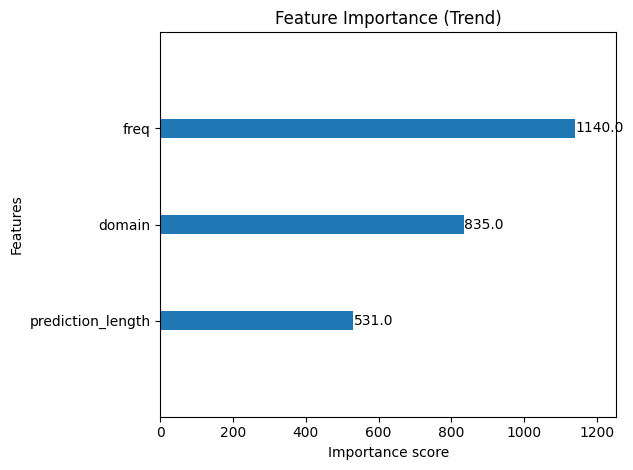

--------------------------------------------------------------------------------
Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'seasonal_strength': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
[Grid Search] Best cross-validation MSE for 'seasonal_strength': 0.045
[Dummy] Test MSE for 'seasonal_strength': 0.079
[XGBoost] Test MSE for 'seasonal_strength': 0.057


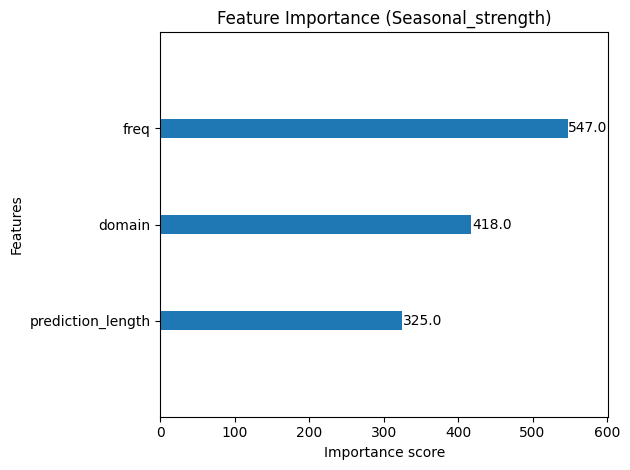

--------------------------------------------------------------------------------
Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'entropy': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
[Grid Search] Best cross-validation MSE for 'entropy': 0.034
[Dummy] Test MSE for 'entropy': 0.035
[XGBoost] Test MSE for 'entropy': 0.035


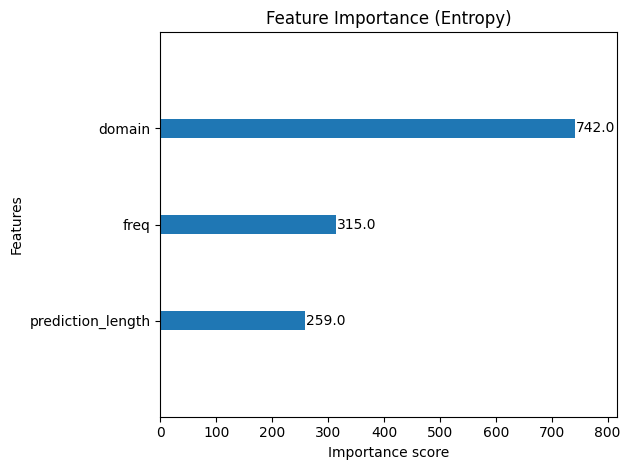

--------------------------------------------------------------------------------
Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'hurst': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
[Grid Search] Best cross-validation MSE for 'hurst': 0.011
[Dummy] Test MSE for 'hurst': 0.033
[XGBoost] Test MSE for 'hurst': 0.028


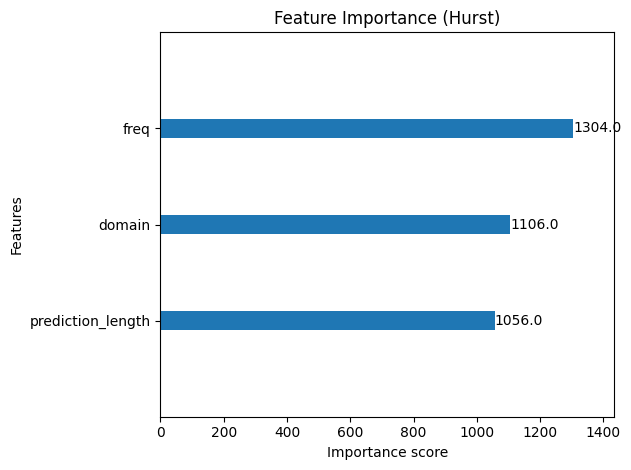

--------------------------------------------------------------------------------
Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'stability': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
[Grid Search] Best cross-validation MSE for 'stability': 0.059
[Dummy] Test MSE for 'stability': 0.091
[XGBoost] Test MSE for 'stability': 0.075


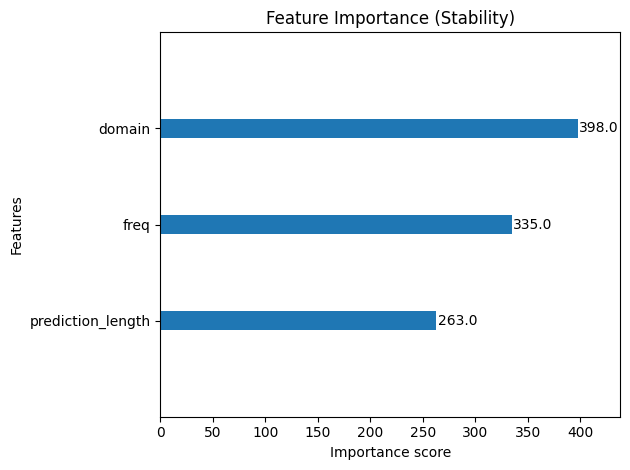

--------------------------------------------------------------------------------
Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters for 'lumpiness': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
[Grid Search] Best cross-validation MSE for 'lumpiness': 0.691
[Dummy] Test MSE for 'lumpiness': 1.185
[XGBoost] Test MSE for 'lumpiness': 0.953


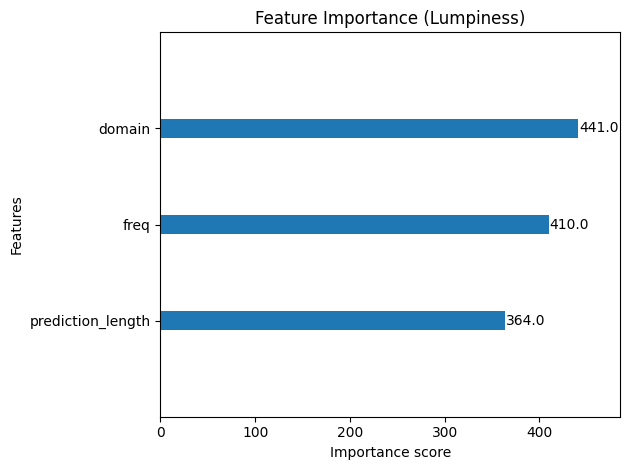

--------------------------------------------------------------------------------


In [8]:
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


# TODO: Decide which params to use for the grid search and their values
# param_grid = {
#     "max_depth": [3, 5, 7],  # Tree depth (complexity)
#     "learning_rate": [0.01, 0.05, 0.1],  # Step size (lower = slower but safer)
#     "n_estimators": [100, 200, 300],  # Number of trees
#     "subsample": [0.7, 0.9, 1.0],  # Row sampling per tree
#     "colsample_bytree": [0.7, 0.9, 1.0],  # Feature sampling per tree
#     "reg_alpha": [0, 0.1, 1.0],  # L1 regularization (sparsity)
#     "reg_lambda": [0.1, 1.0, 10.0],  # L2 regularization (ridge)
# }

# TODO: Consider using bootstrapping

# TODO: Consider using simplier params and regularization
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
}

estimator_dirpath = Path("xgboost_models") / "features"
plot_dirpath = Path("plots") / "features"

for feature in features:
    # Remove irelevant columns for the current feature
    columns = [f for f in features if f != feature] + ["name", "term"]
    df_feature = df.drop(columns=columns)

    X_train, X_test, y_train, y_test = train_test_split(
        df_feature.iloc[:, :-1],
        df_feature.iloc[:, -1],
        test_size=0.2,
        random_state=42,
    )

    grid = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=LeaveOneOut(),
        scoring="neg_mean_squared_error",
        verbose=1,
    ).fit(X_train, y_train)

    print(f"[Grid Search] Best parameters for '{feature}': {grid.best_params_}")
    print(
        f"[Grid Search] Best cross-validation MSE for '{feature}': {-grid.best_score_:.3f}"
    )

    estimator = grid.best_estimator_

    estimator_path = estimator_dirpath / f"{feature}.pkl"
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(estimator, estimator_path)

    dummy = DummyRegressor().fit(X_train, y_train)
    base_mse = mean_squared_error(y_test, dummy.predict(X_test))
    print(f"[Dummy] Test MSE for '{feature}': {base_mse:.3f}")

    y_pred = estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"[XGBoost] Test MSE for '{feature}': {mse:.3f}")

    ax = plot_importance(estimator)
    ax.set_title(f"Feature Importance ({feature.capitalize()})")
    ax.grid(False)
    plt.tight_layout()
    plot_path = plot_dirpath / f"{feature}_importance.png"
    plot_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(plot_path, dpi=300)
    plt.show()

    # TODO: Plot the resulting tree

    print("-" * 80)